In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from create_model import load_model_no_train


In [3]:
print(2)

2


In [2]:
device = "cuda:3"
#checkpoint = "linear12903_50"
#checkpoint = "linear77575_fxj5a68i_390"
#checkpoint = "linear69376_okcpk2bv_170"
checkpoint = "linear62341_6hogpy0g_120"
model = TabPFNClassifier(device=device)#, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model.c
config["num_features"] = 2000
model_pytorch = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model.max_num_features = 2000
model.model = model_pytorch

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7fccb17de160>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [7]:
import pandas as pd
# import train_test_split
from sklearn.model_selection import train_test_split

df = pd.read_csv("tabpfn/prostate.csv")

In [8]:
X, y = df.drop(columns=["y"]), df["y"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train = X_train[X_train.columns[:5000]]
X_test = X_test[X_test.columns[:5000]]

In [15]:
model.fit(X_train, y_train)

TabPFNClassifier(device='cuda:3')

In [16]:
# compute accuracy
model.score(X_test, y_test)

interface
torch.Size([102, 1, 5000])
torch.Size([102, 1])
81


0.42857142857142855

In [17]:
model.predict(X_test)

interface
torch.Size([102, 1, 5000])
torch.Size([102, 1])
81


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [19]:
model.predict_proba(X_test)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 6033 and the array at index 1 has size 10000

In [3]:
# Synthetic high dimensional data
import numpy as np
X = np.random.rand(100, 100)
number_of_relevant_features = 5
relevant_features = np.random.choice(100, number_of_relevant_features, replace=False)
W = np.random.rand(number_of_relevant_features, 1)
y = np.dot(X[:, relevant_features], W)
y = (y > np.median(y)).astype(int).flatten()


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.predict(X_test)

interface
torch.Size([100, 1, 100])
torch.Size([100, 1])
80


array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [89]:
model.score(X_test, y_test)

interface
torch.Size([100, 1, 100])
torch.Size([100, 1])
80


0.75

In [88]:
y_test

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0])

In [25]:
#from tabpfn.priors.flexible_categorical import get_batch
from tabpfn.priors.linear import get_batch as get_batch_linear
from tabpfn.priors.flexible_categorical import MulticlassRank, BalancedBinarize

def get_batch_func(num_features, train_size):
    hyperparameters = {"random_feature_removal": 0., "random_feature_removal_min":0.,
                      "n_relevant_features_min": 5, "n_relevant_features_max": 100,
                      "random_feature_removal_min": 0.7,
                    "correlation_strength_min": 0, "correlation_strength_max": 0,
                    "correlation_proba_min": 0, "correlation_proba_max": 0,
                    "p_categorical": 0,
                    "sampling": "normal",
                    "output_multiclass_ordered_p": 0.0,
                    "curriculum": False,
                    "seq_len_used": 50,
                    "num_features_used": 100,
                    "num_classes": 10,
                    "balanced": False,
                      'aggregate_k_gradients': 8,
  # 'recompute_attn': True,
  # 'bptt_extra_samples': None,
  # 'bptt': 1152,
  # 'dynamic_batch_size': False,
  # 'multiclass_loss_type': 'nono',
  # 'output_multiclass_ordered_p': 0.0,
  # 'normalize_with_sqrt': False,
  # 'new_mlp_per_example': True,
  # 'prior_mlp_scale_weights_sqrt': True,
  # 'batch_size_per_gp_sample': None,
  # 'normalize_ignore_label_too': False,
  # 'differentiable_hps_as_style': False,
  # 'random_feature_rotation': True,
  # 'rotate_normalized_labels': True,
  # 'normalize_on_train_only': True,
  # 'mix_activations': False,
  # 'weight_decay': 0.0,
  # 'use_flash_attention': True,
  # 'canonical_y_encoder': False,
  # 'total_available_time_in_s': None,
  # 'train_mixed_precision': True,
  # 'efficient_eval_masking': True,
  # 'hardware_batch_size': 4,
  # 'num_global_att_tokens': 0,
  # 'use_seperate_decoder': False,
  # 'attend_to_global_tokens_only_at_test': False,
  # "max_eval_pos": 1000,
  # 'lr': 0.0001,
  # 'dropout': 0.0,
  # 'emsize': 512,
  # 'batch_size': 64,
  # 'nlayers': 12,
  # 'num_features': 100,
  # 'nhead': 4,
  # 'nhid_factor': 2,
  # 'eval_positions': None,
  # 'sampling': 'mixed',
  # 'epochs': 400,
  # 'num_steps': 128,
  # 'verbose': False,
  # 'pre_sample_causes': True,
  # 'multiclass_type': 'rank',
  # 'nan_prob_unknown_reason_reason_prior': 1.0,
  # 'categorical_feature_p': 0.0, #TODO
  # 'nan_prob_no_reason': 0.0,
  # 'nan_prob_unknown_reason': 0.0,
  # 'nan_prob_a_reason': 0.0,
  # 'max_num_classes': 10,
  # 'num_classes': 10,
  # 'noise_type': 'Gaussian',
  # 'balanced': False,
  # 'normalize_to_ranking': False,
  # 'set_value_to_nan': 0.1,
  # 'normalize_by_used_features': True,
  # #'num_features_used': {'num_features_func': None},
  # 'num_categorical_features_sampler_a': -1.0,
    }
    hyperparameters['sampling'] = "mixed"
    args = {}
    args["remove_outliers_in_flexible_categorical"] = False
    args["normalize_x_in_flexible_categorical"] = False
    args["random_feature_rotation"] = False
    args["assign_class_in_flexible_categorical"] = True
    hyperparameters['normalize_labels'] = True
    hyperparameters['check_is_compatible'] = True
    hyperparameters['normalize_labels'] = True
                    
    X, y, _ = get_batch_linear(batch_size=1,
            #get_batch=get_batch_linear,
            #device=device,
            seq_len=1152,
            num_features_max=num_features,
            num_features_sampler= lambda: num_features,
            #single_eval_pos=600,
            hyperparameters=hyperparameters,
            **args)
    
    # # standardize y
    # y = (y - torch.mean(y)) / torch.std(y)

    class_assigner = MulticlassRank(num_classes=2, ordered_p=hyperparameters["output_multiclass_ordered_p"])
    # #class_assigner = BalancedBinarize()
    y = class_assigner(y)
    # #print(np.unique(y, return_counts=True))
    # # normalize y
    # for b in range(y.shape[1]):
    #     valid_labels = y[:,b] != -100
    #     # if self.h.get('normalize_ignore_label_too', False):
    #     #         valid_labels[:] = True
    #     y[valid_labels, b] = (y[valid_labels, b] > y[valid_labels, b].unique().unsqueeze(1)).sum(axis=0).unsqueeze(0)
    X = X.reshape(X.shape[0], X.shape[2])
    y = y.reshape(y.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [26]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
rf = RandomForestClassifier()
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
clf_lasso = LogisticRegression(random_state=0, penalty="l1", max_iter=1000, solver="liblinear")
clf_l2 = LogisticRegression(random_state=0, max_iter=1000)
gbt = GradientBoostingClassifier()


In [27]:
#train_sizes = [10, 100, 600]
train_sizes = [600]
num_features_list = [10, 50, 100, 200]
model_names = ["tabpfn_curriculum", "lasso", "linear"]
models = [model_curriculum, clf_lasso, clf_l2]
n_batch = 10
scores = np.zeros((len(train_sizes), len(num_features_list), len(model_names), n_batch))
for i, train_size in enumerate(train_sizes):
    for j, num_features in enumerate(num_features_list):
        for k in range(n_batch):
            X_train, X_test, y_train, y_test = get_batch_func(num_features=num_features, train_size=train_size)
            for l, (model_name, model) in enumerate(zip(model_names, models)):
                if X_train.shape[1] > 100 and "original" in model_name:
                    scores[i, j, l, k] = np.nan
                    continue
                if np.unique(y_train).shape[0] == 1 or np.unique(y_test).shape[0] == 1:
                    scores[i, j, l, k] = np.nan
                    continue
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                scores[i, j, l, k] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
                print(f"model: {model_name}, train_size: {train_size}, num_features: {num_features}, score: {scores[i, j, l, k]}")
            
            
            
        

model: tabpfn_curriculum, train_size: 600, num_features: 10, score: 0.7608448784919373
model: lasso, train_size: 600, num_features: 10, score: 0.96286622757211
model: linear, train_size: 600, num_features: 10, score: 0.9059732000908471
model: tabpfn_curriculum, train_size: 600, num_features: 10, score: 0.6666666666666665
model: lasso, train_size: 600, num_features: 10, score: 0.8666666666666667
model: linear, train_size: 600, num_features: 10, score: 0.6666666666666665
model: tabpfn_curriculum, train_size: 600, num_features: 10, score: 0.8786639400136331
model: lasso, train_size: 600, num_features: 10, score: 0.962118998928815
model: linear, train_size: 600, num_features: 10, score: 0.8827539195637355
model: tabpfn_curriculum, train_size: 600, num_features: 10, score: 0.9652061334304325
model: lasso, train_size: 600, num_features: 10, score: 0.9795687178864749
model: linear, train_size: 600, num_features: 10, score: 0.9615649148359429
model: tabpfn_curriculum, train_size: 600, num_feat

In [28]:
#Transform the scores into a dataframe
import pandas as pd
df = pd.DataFrame()
for i, train_size in enumerate(train_sizes):
    for j, num_features in enumerate(num_features_list):
        for l, model_name in enumerate(model_names):
            for k in range(n_batch):
                df = pd.concat([df, pd.DataFrame({"train_size": train_size, "num_features": num_features, "model_name": model_name, "score": scores[i, j, l, k]}, index=[0])], ignore_index=True)


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


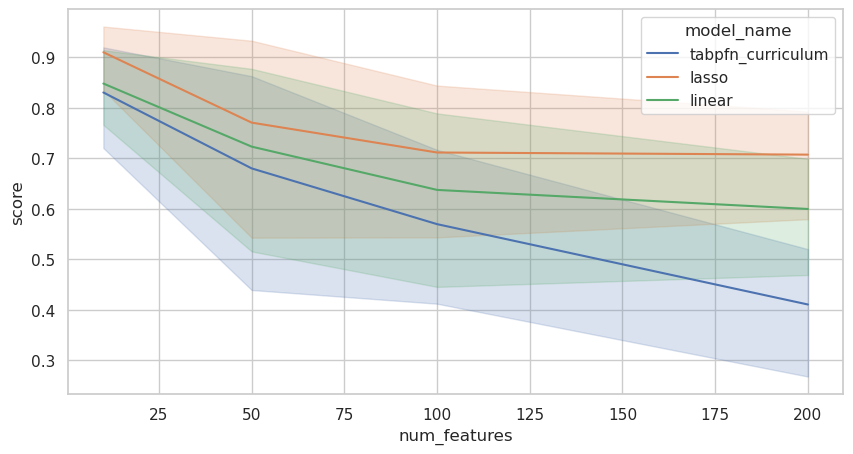

In [29]:
df_600 = df[df["train_size"] == 600]

# plot the results
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# one line per model
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="num_features", y="score", hue="model_name", data=df_600)


In [5]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
clf_lasso = LogisticRegression(random_state=0, penalty="l1", max_iter=1000, solver="liblinear")
clf_l2 = LogisticRegression(random_state=0, max_iter=1000)
gbt = GradientBoostingClassifier()

In [25]:
import torch
n_iter = 12
res_tabpfn = []
res_lasso = []
res_linear = []
res_gbt = []
for _ in range(n_iter):
    X_train, X_test, y_train, y_test = get_batch_func()
    if np.unique(y_train).shape[0] == 1:
        continue
    model.fit(X_train, y_train)
    clf_lasso.fit(X_train, y_train)
    clf_l2.fit(X_train, y_train)
    #gbt.fit(X_train, y_train)
    res_tabpfn.append(balanced_accuracy_score(y_test, model.predict(X_test), adjusted=True))
    res_lasso.append(balanced_accuracy_score(y_test, clf_lasso.predict(X_test), adjusted=True))
    res_linear.append(balanced_accuracy_score(y_test, clf_l2.predict(X_test), adjusted=True))
    #res_gbt.append(balanced_accuracy_score(y_test, gbt.predict(X_test)))

In [5]:
import matplotlib.pyplot as plt
plt.scatter(range(n_iter), res_tabpfn, label="tabpfn", alpha=0.4)
plt.scatter(range(n_iter), res_lasso, label="lasso", alpha=0.4)
plt.scatter(range(n_iter), res_linear, label="linear", alpha=0.4)
#plt.scatter(range(n_iter), res_gbt, label="gbt", alpha=0.4)
plt.legend()

NameError: name 'n_iter' is not defined

# Actual data

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
rf = RandomForestClassifier()
clf_lasso = LogisticRegression(random_state=0, penalty="l1", max_iter=1000, solver="liblinear")
clf_l2 = LogisticRegression(random_state=0, max_iter=1000, penalty="l2")
gbt = GradientBoostingClassifier()
device = "cuda:3"

In [31]:
df_train = pd.read_csv("datasets/stem-cell-predcition/train.csv")
df_test = pd.read_csv("datasets/stem-cell-predcition/test.csv")
target = "stem"
X = df_train.drop(columns=[target])
y = df_train[target]
#X_test = df_test.drop(columns=[target]) # does not exist
#y_test = df_test[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=43)

In [32]:
print("shapes", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

shapes (100, 967) (50, 967) (100,) (50,)


In [33]:
model_names = ["tabpfn_5", "tabpfn_10", "lasso", "linear", "rf", "gbt"]
models = [model_5_step, model_10_step, clf_lasso, clf_l2, rf, gbt]
for model_name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model_name, balanced_accuracy_score(y_test, y_pred, adjusted=True))

tabpfn_5 0.9666666666666668
tabpfn_10 0.9666666666666668
lasso 1.0
linear 0.95
rf 0.95
gbt 0.95


In [5]:
import openml
import matplotlib.pyplot as plt

In [4]:
device = "cuda:3"

In [6]:
tabpfn_original = TabPFNClassifier(device=device)
tabpfn_original_no_prepro = TabPFNClassifier(device=device, no_preprocess_mode=True)

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7f968561a3a0>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [8]:
checkpoint = "linear65131_aajl8wbt_180"
model_curriculum2 = TabPFNClassifier(device=device, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model_curriculum2.c
config["num_features"] = 2000
model_curriculum2.c["max_num_features"] = 2000
model_curriculum_pytorch2 = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model_curriculum2.max_num_features = 2000
model_curriculum2.model = model_curriculum_pytorch2

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7f968561ac10>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [5]:
#checkpoint = "linear48760_a04e9ul7_150"
device = "cuda:3"
checkpoint = "linear28077_28277w7g_90"
model_curriculum = TabPFNClassifier(device=device, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model_curriculum.c
config["num_features"] = 2000
model_curriculum.c["max_num_features"] = 2000
model_curriculum_pytorch = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model_curriculum.max_num_features = 2000
model_curriculum.model = model_curriculum_pytorch

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7fbc4fd551f0>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [9]:
checkpoint = "linear62341_6hogpy0g_150"
model_5_step = TabPFNClassifier(device=device, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model_5_step.c
config["num_features"] = 2000
model_5_step.c["max_num_features"] = 2000
model_pytorch_5_step = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model_5_step.max_num_features = 2000
model_5_step.model = model_pytorch_5_step

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7fccb1828c10>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [10]:
checkpoint = "linear44856_62y4rq7r_210"
model_10_step = TabPFNClassifier(device=device, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model_10_step.c
config["num_features"] = 2000
model_10_step.c["max_num_features"] = 2000
model_pytorch_10_step = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model_10_step.max_num_features = 2000
model_10_step.model = model_pytorch_10_step

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7fccb1828700>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [144]:
dataset_id = 45019
#dataset_id = 1480
#dataset_id = 1510
#dataset_id = 1467
import openml
dataset = openml.datasets.get_dataset(dataset_id)
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=700, random_state=42)

In [14]:
from sklearn.model_selection import cross_val_score

In [154]:
model_5_step.fit(X_train, y_train)
#model_5_step.predict(X_test)

TabPFNClassifier(device='cuda:3', no_preprocess_mode=True)

In [155]:
model_5_step.fit(X_train, y_train)
model_5_step.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
dataset_ids = [45021]#[45019, 1467, 1480, 1510]
model_names = ["tabpfn_original", "tabpfn_original_no_prepro", "tabpfn_5", "tabpfn_10", "lasso", "linear", "rf"]
models = [tabpfn_original, tabpfn_original_no_prepro, model_5_step, model_10_step, clf_lasso, clf_l2, rf]
n_folds = 6
all_scores = np.zeros((len(dataset_ids), len(model_names), n_folds))
for dataset_id in dataset_ids:
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )
    for model_name, model in zip(model_names, models):
        print(model_name)
        # cross validation
        for k in range(n_folds):
            try:
                X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=400, random_state=42+k)
                model.fit(X_train, y_train)
                all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), k] = balanced_accuracy_score(y_test, model.predict(X_test), adjusted=False)
            except:
                print(f"error on {dataset_id} {model_name} {k}")
        #scores = cross_val_score(model, X, y, cv=n_folds, scoring="balanced_accuracy", fit_params={"overwrite_warning": True} if model_name.startswith("tabpfn") else {}) #reset the model
        #all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), :] = scores

tabpfn_original
tabpfn_original_no_prepro
tabpfn_5
tabpfn_10
lasso
linear


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

rf


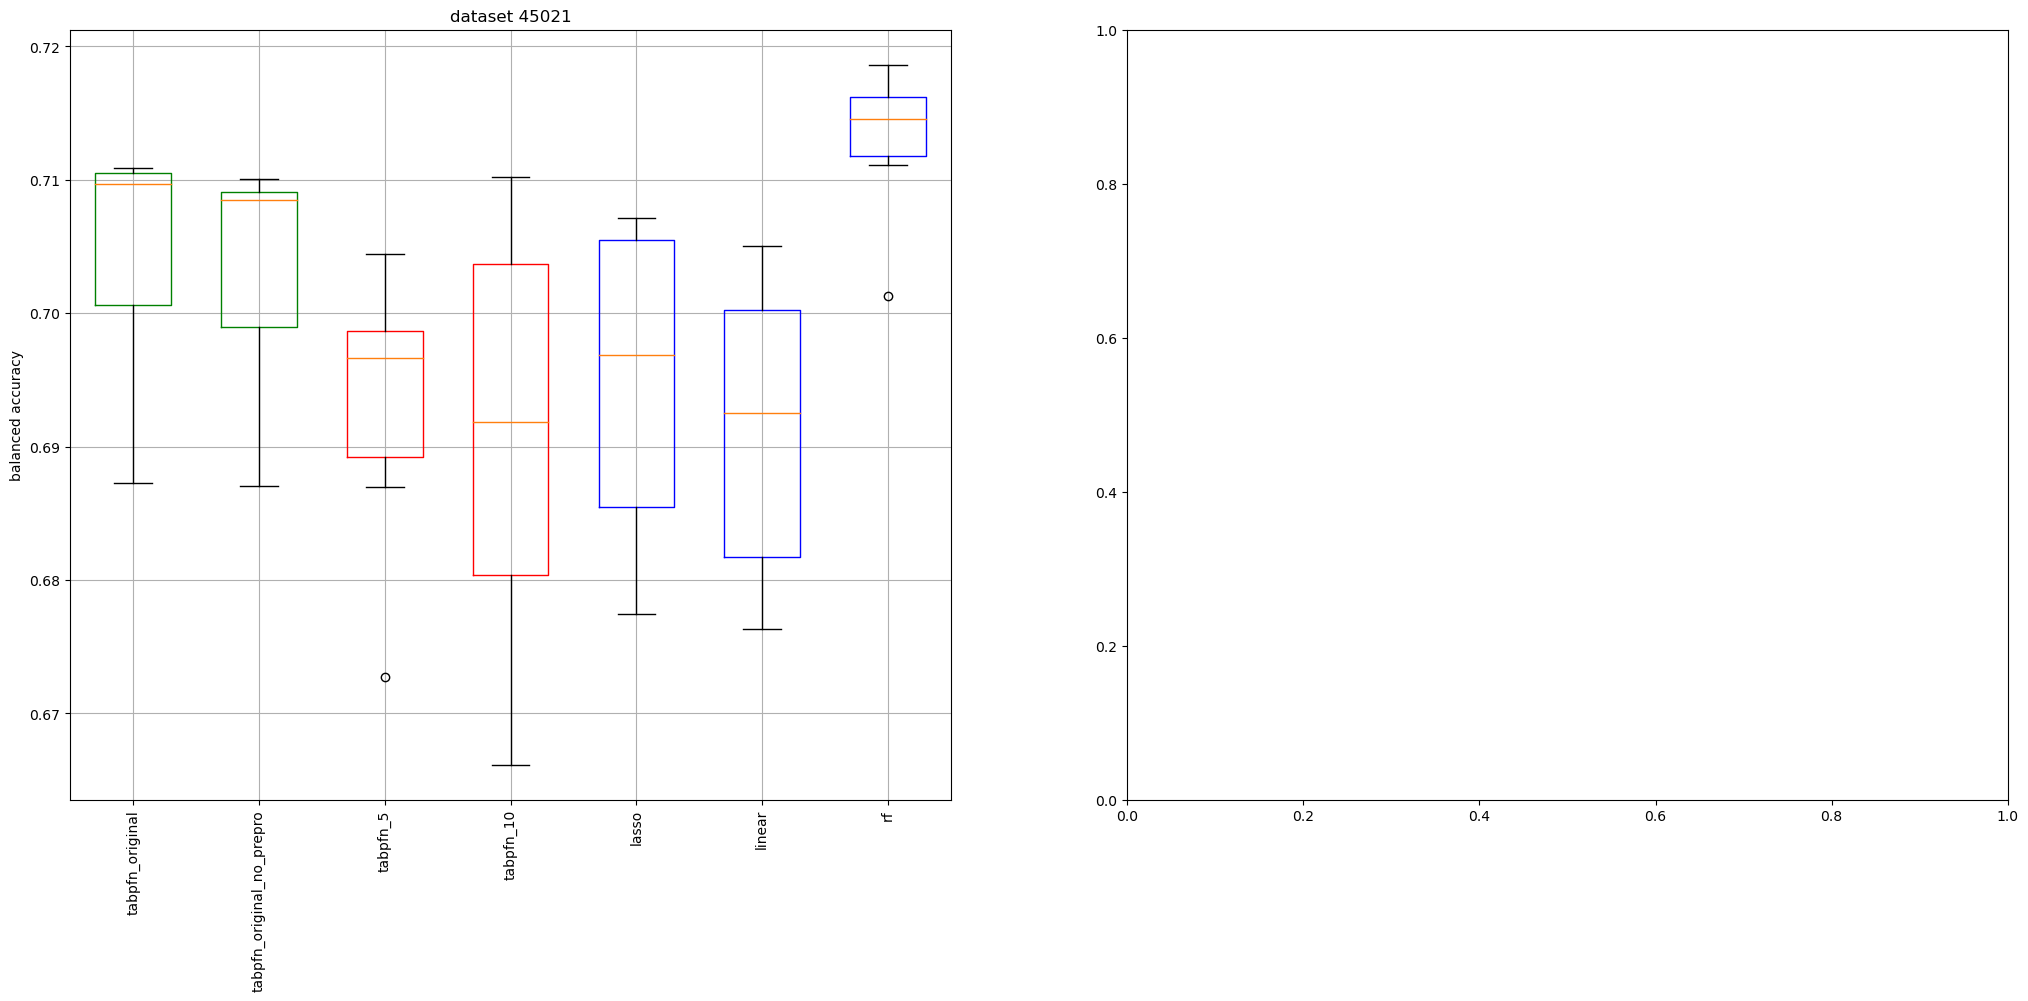

In [25]:
# plot results with subplots per dataset
# replace 0 by nan
all_scores[all_scores == 0] = np.nan
fig, axes = plt.subplots(nrows=1, ncols=len(dataset_ids) + 1, figsize=(25, 10))
for i, dataset_id in enumerate(dataset_ids):
    for j, (model_name, model) in enumerate(zip(model_names, models)):
        if "tabpfn" in model_name:
            # fill box in red
            if "original" in model_name:
                axes[i].boxplot(all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="green"))
            else:
                axes[i].boxplot(all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="red"))
        else:
            axes[i].boxplot(all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="blue"))
        axes[i].set_xticks(range(len(model_names)))
        axes[i].set_xticklabels(model_names)
        axes[i].set_title(f"dataset {dataset_id}")
        axes[i].set_ylabel("balanced accuracy")
        axes[i].grid(True)
        # rotate x tick labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)

In [24]:
all_scores

array([[[       nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan],
        [0.71384104, 0.75395336, 0.77622378, 0.70454545, 0.7465035 ,
         0.76223776],
        [0.7225762 , 0.74699081, 0.77797203, 0.72377622, 0.74300699,
         0.76923077],
        [0.77144806, 0.77138106, 0.80244755, 0.7972028 , 0.77272727,
         0.80769231]],

       [[0.5       , 0.67530488, 0.55640244, 0.5       , 0.5       ,
         0.5       ],
        [0.5       , 0.67530488, 0.55640244, 0.5       , 0.5       ,
         0.5       ],
        [0.66920732, 0.60670732, 0.55640244, 0.67530488, 0.48795181,
         0.5       ],
        [0.61890244, 0.61280488, 0.5625    , 0.67530488, 0.5       ,
         0.5       ],
        [0.5       , 0.49390244, 0.5       , 0.5625    , 0.4939759 ,
         0.5       ]],

       [[0.57142857, 0.58968254, 0.57091097, 0.64078675, 0.5636646 ,
         0.582039

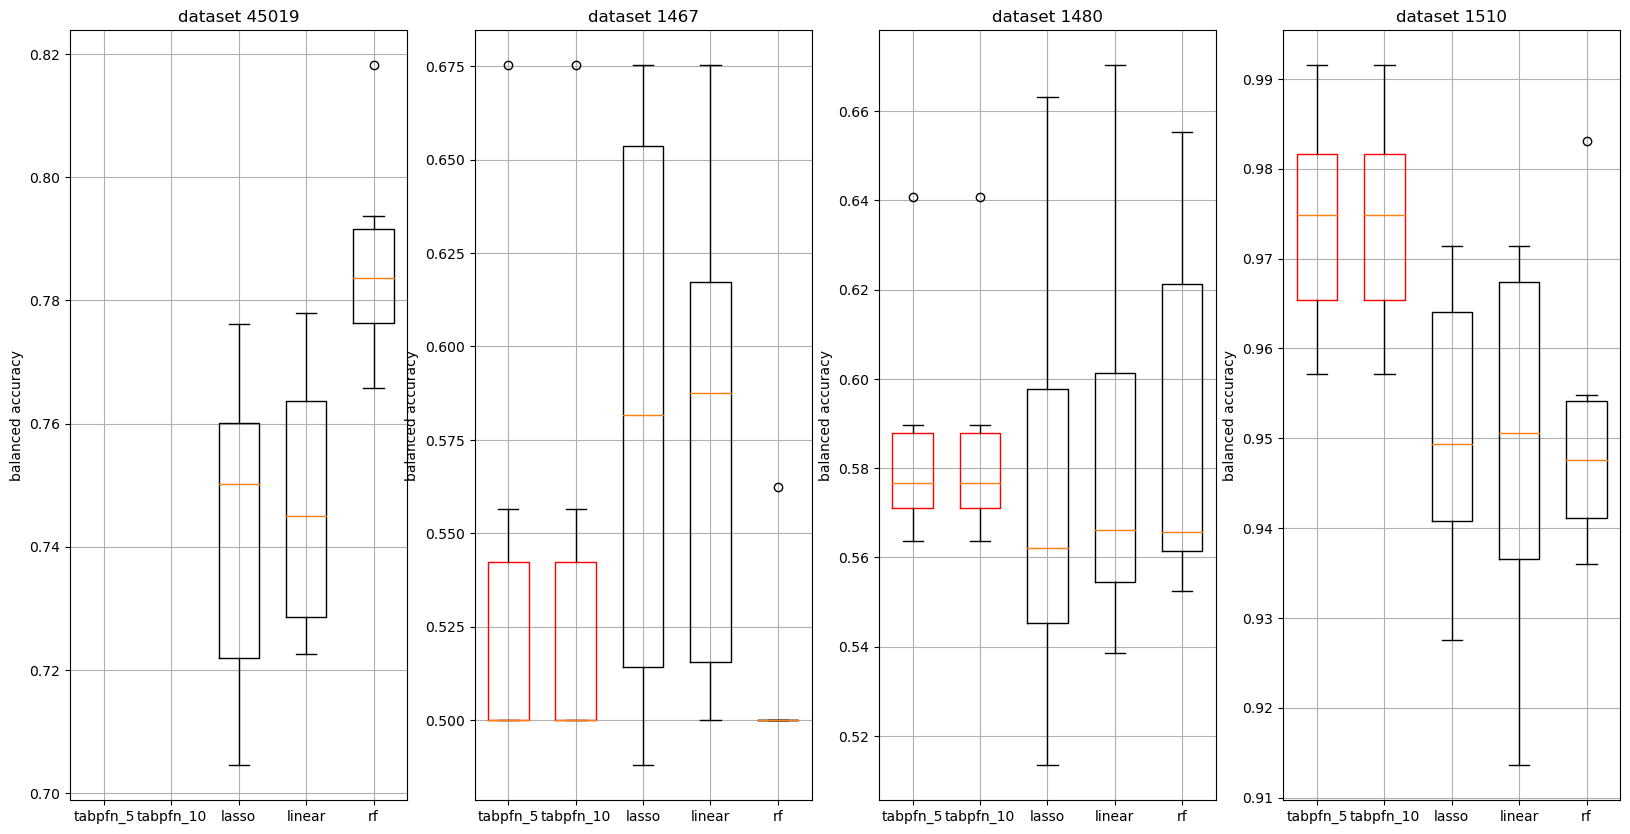

In [19]:
# plot results with subplots per dataset
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=len(dataset_ids), figsize=(20, 10))
for i, dataset_id in enumerate(dataset_ids):
    for j, (model_name, model) in enumerate(zip(model_names, models)):
        if "tabpfn" in model_name:
            # fill box in red
            axes[i].boxplot(all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="red"))
        else:
            axes[i].boxplot(all_scores[dataset_ids.index(dataset_id), model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6)
        axes[i].set_xticks(range(len(model_names)))
        axes[i].set_xticklabels(model_names)
        axes[i].set_title(f"dataset {dataset_id}")
        axes[i].set_ylabel("balanced accuracy")
        axes[i].grid(True)

In [130]:
all_scores

array([[[0.98214286, 1.        , 0.96428571, 0.94739057, 0.98148148,
         1.        ],
        [0.98214286, 1.        , 0.96428571, 0.94739057, 0.98148148,
         1.        ],
        [0.93563123, 0.97051495, 0.95265781, 0.89604377, 0.96296296,
         0.93308081],
        [0.93563123, 0.98837209, 0.97051495, 0.91456229, 0.94444444,
         0.93308081],
        [0.95888704, 1.        , 0.95265781, 0.92592593, 0.90319865,
         0.98863636]],

       [[0.98214286, 1.        , 0.96428571, 0.94739057, 0.98148148,
         1.        ],
        [0.98214286, 1.        , 0.96428571, 0.94739057, 0.98148148,
         1.        ],
        [0.93563123, 0.97051495, 0.95265781, 0.89604377, 0.96296296,
         0.93308081],
        [0.93563123, 0.98837209, 0.97051495, 0.91456229, 0.94444444,
         0.93308081],
        [0.95888704, 0.98837209, 0.96428571, 0.92592593, 0.95159933,
         1.        ]],

       [[0.98214286, 1.        , 0.96428571, 0.94739057, 0.98148148,
         1.      

In [100]:
from sklearn.metrics import accuracy_score
print("Score tabpfn", accuracy_score(y_test, model.predict(X_test)))
print("Score lasso", accuracy_score(y_test, clf_lasso.predict(X_test)))
print("Score linear", accuracy_score(y_test, clf_l2.predict(X_test)))
print("Score rf", accuracy_score(y_test, rf.predict(X_test)))

Score tabpfn 0.965034965034965
Score lasso 0.965034965034965
Score linear 0.958041958041958
Score rf 0.9370629370629371


In [17]:
X = X.reshape(X.shape[0], X.shape[2])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
model.fit(X_train, y_train)

/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TabPFNClassifier(device='cuda:3')

In [20]:
model.score(X_test, y_test)

interface
torch.Size([1000, 1, 10])
torch.Size([1000, 1])
800


0.995

In [21]:
model.predict(X_test)

interface
torch.Size([1000, 1, 10])
torch.Size([1000, 1])
800


array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [22]:
import torch
import numpy as np
# Baselines
# Predict the most common class
most_common_class = np.bincount(y_train.reshape(-1)).argmax()
print(f"Accuracy: {torch.sum(y_test == most_common_class) / len(y_test)}")

least_common_class = np.bincount(y_train.reshape(-1)).argmin()
print(f"Accuracy: {torch.sum(y_test == least_common_class) / len(y_test)}")


Accuracy: 0.8799999952316284
Accuracy: 0.11999999731779099


In [10]:
# Lasso for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier().fit(X_train, y_train)
clf = LogisticRegression(random_state=0, penalty="l1", solver="saga", max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

NameError: name 'X_train' is not defined

0.97

In [2]:
import scipy

In [4]:
import time
import numpy as np

In [27]:
start = time.time()
for i in range(10):
    normal = scipy.stats.norm.rvs(loc=0, scale=1, size=(1000, 1, 10000), random_state=None)
print(time.time() - start)

8.077756643295288


In [7]:
start = time.time()
for i in range(1):
    normal = np.random.normal(loc=0, scale=1, size=(1000, 1, 10000))
print(time.time() - start)

0.5950906276702881


In [12]:
from numba import njit

@njit(parallel=True)
def generate_random_values(shape):
    return np.random.normal(0, 1, shape)

# Call the function once to compile it
_ = generate_random_values((1, 1))

# Now you can use the optimized function
random_values = generate_random_values((1000, 10000))

In [28]:
start = time.time()
for i in range(10):
    random_values = generate_random_values((1000, 1, 10000))
print(time.time() - start)

1.1224868297576904


In [30]:
import torch

In [39]:
start = time.time()
torch.normal(mean=torch.zeros(1000, 10, 10000), std=torch.ones(1000, 10, 10000))
print(time.time() - start)

1.2172961235046387


In [ ]:
from tabpfn.priors.trees import get_batch
from tabpfn.priors.flexible_categorical import MulticlassRank, BalancedBinarize, MulticlassValue
import numpy as np

hyperparameters = {"n_estimators_lambda": 0.15, "max_depth_lambda": 0.35,
                   "n_estimators": None,
                   "num_classes": 10,
                   "randomize_leaves": False,
                   "return_classes": False,
                   "correlation_strength_min": 0, "correlation_strength_max": 0,
                   "correlation_proba_min": 0, "correlation_proba_max": 0,
                   "p_categorical": 0,
                   "sampling": "normal",
                   "output_multiclass_ordered_p": 0.0,
}
                   
X, y, _ = get_batch(batch_size=1,
          seq_len=1000,
          num_features=2,
          hyperparameters=hyperparameters)

# normalize y
y = (y - y.min()) / (y.std())
class_assigner = MulticlassRank(num_classes=10, ordered_p=hyperparameters["output_multiclass_ordered_p"])
#class_assigner = MulticlassValue(num_classes=hyperparameters["num_classes"])
#class_assigner = BalancedBinarize()
y = class_assigner(y)

10 2
0.0


In [ ]:
import numpy as np
np.unique(y, return_counts=True)

(array([0, 1]), array([381, 619]))

In [ ]:
X

tensor([[[ 0.6092,  0.1397]],

        [[ 0.4390, -0.6159]],

        [[-1.0634,  0.1834]],

        ...,

        [[ 0.2965, -1.2584]],

        [[-0.8430,  0.2685]],

        [[-0.8229, -1.7594]]])

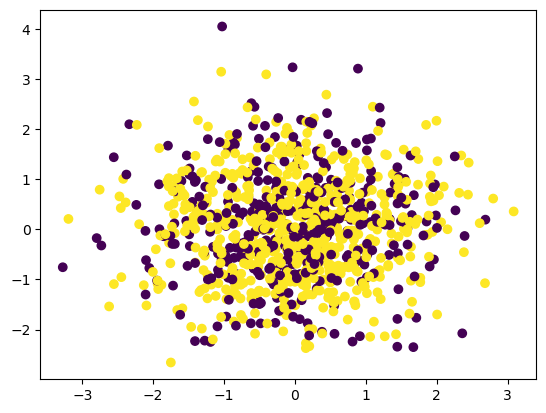

In [ ]:
import matplotlib.pyplot as plt
X = X.reshape(X.shape[0], X.shape[2])
plt.scatter(X[:, 0], X[:, 1], c=y)